# 콘텐츠 기반필터링 실습 - TMDB 5000 영화 데이터 세트

## 콘텐츠 기반 필터링
## 사용자가 특정 영화를 감사하고 그 영하를 좋아했다면 그 영화과 비슷한 특성/ 속성, 구성 요소 등을 가진 다른 영화를 추천하는 것

### 데이터 로딩 및 가공

In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

In [7]:
movies = pd.read_csv('tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


### > 4803개의 레코드와 2-개의 피처로 구성
### > 영화 제목, 개요, 인기도, 평점, 투표수, 예산, 키워드 등 영화에 대한 다양한 메타 정보

In [10]:
movies_df = movies[['id','title','genres','vote_average','vote_count','popularity','keywords','overview']]

In [12]:
pd.set_option('max_colwidth', 100)
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


### > 장르 칼럼은 여러개의 개별 장르 데이터를 가지고 있고, 개별 장르의 명칭은 딕셔너리의 키인 name으로 추출 가능

In [13]:
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

### 장르명만 리스트 객체로 추출

In [15]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


## 장르 콘텐츠 유사도 측정

### 장르를 문자열로 변경한 뒤 이를 CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교하는 것

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


In [18]:
movies_df['genres_literal']

0       Action Adventure Fantasy Science Fiction
1                       Adventure Fantasy Action
2                         Action Adventure Crime
3                    Action Crime Drama Thriller
4               Action Adventure Science Fiction
                          ...                   
4798                       Action Crime Thriller
4799                              Comedy Romance
4800               Comedy Drama Romance TV Movie
4801                                            
4802                                 Documentary
Name: genres_literal, Length: 4803, dtype: object

### > CountVectorizer로 변환해 4803개의 레코드아 276개의 개별 단어 피처로 구성된 피처 벡터 행렬 생성

## 코사인 유사도 계산

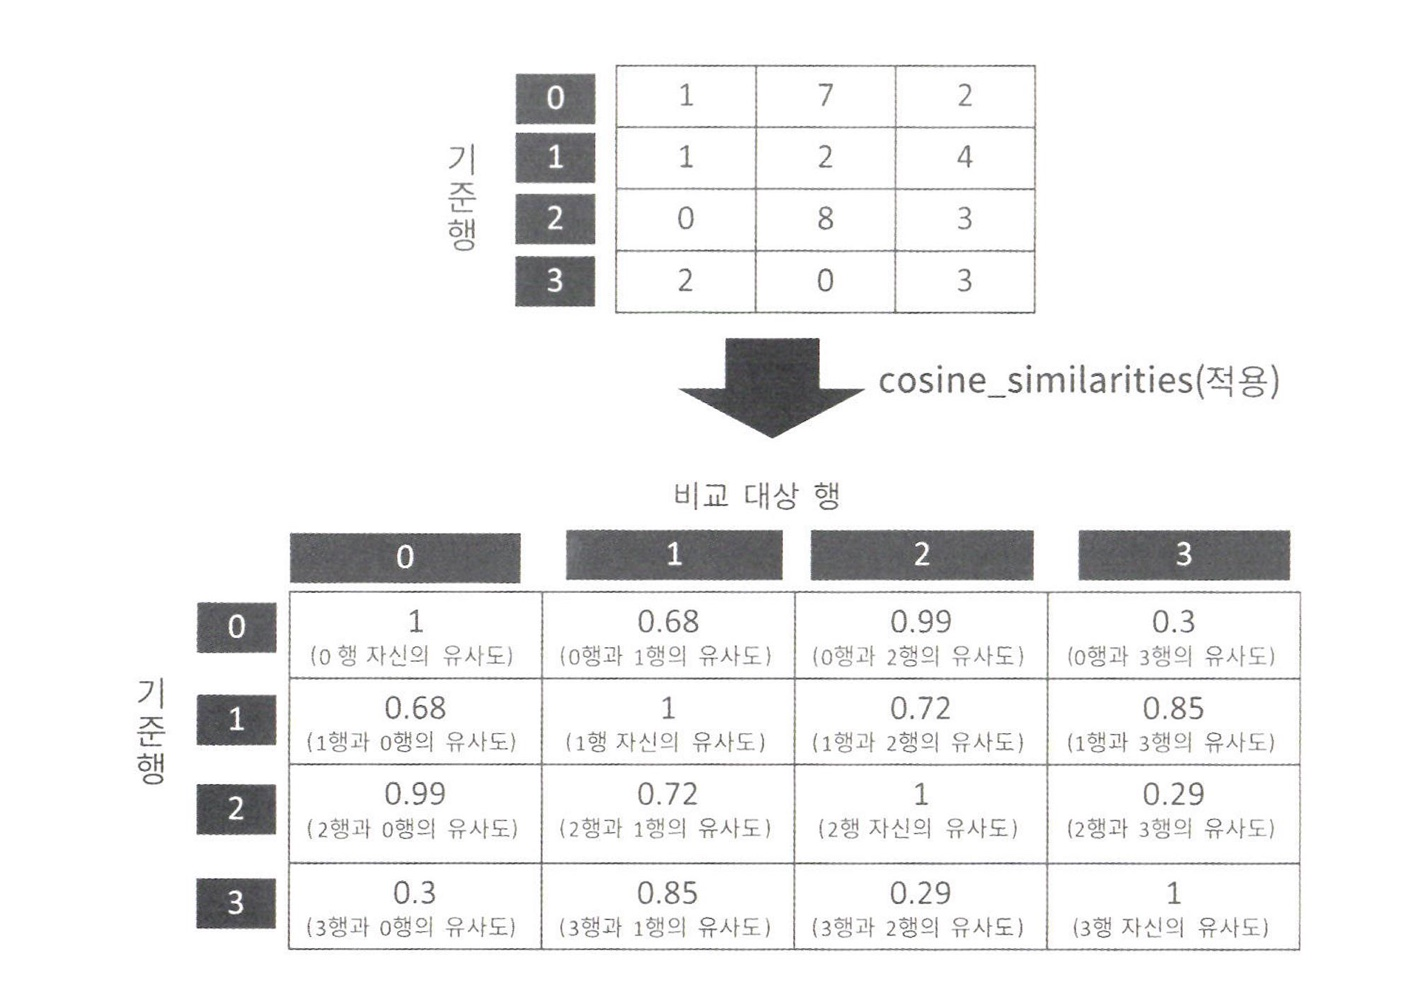

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


In [24]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


### > 반환된 리스트가 의미하는 것은 0번 레코드의 경우 자신인 0번 레코드를 제외하면 3494번 레코드가 가장 유사도가 높고, 그 다음이 813번 레코드이며, 가장 유사도가 낮은 렠드는 2401번 레코드라는 뜻

# 장르 콘텐츠 필터링을 이용한 영화 추천

In [38]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]
    
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)
    
    return df.iloc[similar_indexes]

In [39]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


In [42]:
movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


In [43]:
percentile = 0.6
m = movies['vote_count'].quantile(percentile)
C = movies['vote_average'].mean()

In [46]:
def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C)

movies['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [50]:
movies[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values( 'weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


In [55]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    return df.iloc[similar_indexes].sort_values('weighted_vote',ascending=False)[:top_n]

similar_movies = find_sim_movie(movies, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average','weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
